In [85]:
#pip install matplotlib
#!pip install scikit-learn #ensures it's installed in the correct env
#pip install -U scikit-learn

In [131]:
#imports only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats


In [132]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)

data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [133]:
#random sampling
def split_train_test(data, test_ratio): 
    shuffled_indices = np.random.permutation(len(data)) #creates array of indices that are randomly shuffled
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#stratified sampling
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42)
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
train_set, test_set = stratified_sampling(data, 0.2, data["age"])
test_set = strat_test_set
train_set = strat_train_set
print(len(test_set))
print(len(train_set))

1142
4568


In [134]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)

#add distance groups
# Create bins for distance ranging from 0 to 2000 with a step size of 100
distance_bins = np.arange(0, 2001, 100)

# Create labels for distance bins
distance_labels = [f'{i}-{i+100}' for i in range(0, 2000, 100)]

# Assign each distance value to a corresponding bin
data['distance_groups'] = pd.cut(data['dist'], bins=distance_bins, labels=distance_labels, right=False)

#skapa

In [135]:
#create age groups
from pandas.plotting import scatter_matrix
import seaborn as sns

print(data.columns)
binary_attributes = ['heard', 'building', 'noise', 'in_vehicle', 'asleep', 'no_windows']

#Comparing age and heard
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age',
       'dist', 'distance_groups'],
      dtype='object')


# (i) Does the distance to the nearest horn affect whether a person hears the siren or not?

In [162]:
# for each age group
# count number of heard of the total age group size
# store in a new array

data['distance_groups'] = data['distance_groups'].astype(str)
distance_heard_percentage = []
distance_group_array = []



for distance in sorted(data["distance_groups"].unique(), key=custom_sort): 
    subset_data = data.loc[data['distance_groups'] == distance]
    heard_count = (subset_data['heard'] == 1).sum()
    total_count = len(subset_data)
    percentage_heard_per_distance = heard_count/total_count
    distance_group_array.append(distance)
    distance_heard_percentage.append(percentage_heard_per_distance)
    

#print(distance_group_array)
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(distance_group_array, distance_heard_percentage, color='skyblue')
plt.xlabel('Distance Groups')
plt.ylabel('% Heard')
plt.title('Percentage Heard Based on Distance Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines to y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
#plt.show()

custom_ticks = [i/10 for i in range(11)]  # Custom ticks from 0 to 1 with step size 0.1
plt.yticks(custom_ticks, [f"{tick:.1f}" for tick in custom_ticks])

plt.grid(axis='y')  # Add gridlines to y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

ValueError: invalid literal for int() with base 10: 'nan'

In [4]:
data.describe()
#from this we see that 25% have age under 35yo, 50% below 50yo and 75% below 66yo. Max age is 88yo

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,0.248687,1.796497e+06,8.283723e+06,0.190893,0.094046,0.006130,0.023643,50.635902
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,0.432290,2.789790e+05,5.369782e+05,0.393039,0.291918,0.078058,0.151947,18.630865
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,0.000000,1.244893e+06,7.432236e+06,0.000000,0.000000,0.000000,0.000000,18.000000
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,0.000000,1.529848e+06,7.919276e+06,0.000000,0.000000,0.000000,0.000000,35.000000
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,0.000000,1.891302e+06,8.251345e+06,0.000000,0.000000,0.000000,0.000000,50.000000
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,0.000000,2.003743e+06,8.368852e+06,0.000000,0.000000,0.000000,0.000000,66.000000
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,1.000000,2.686256e+06,1.042743e+07,1.000000,1.000000,1.000000,1.000000,88.000000


In [5]:
data.info()
#we see that we have no null objects

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5710 entries, 0 to 5709
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   near_fid    5710 non-null   int64  
 1   near_x      5710 non-null   float64
 2   near_y      5710 non-null   float64
 3   near_angle  5710 non-null   float64
 4   heard       5710 non-null   int64  
 5   building    5710 non-null   int64  
 6   xcoor       5710 non-null   float64
 7   ycoor       5710 non-null   int64  
 8   noise       5710 non-null   int64  
 9   in_vehicle  5710 non-null   int64  
 10  asleep      5710 non-null   int64  
 11  no_windows  5710 non-null   int64  
 12  age         5710 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 580.0 KB


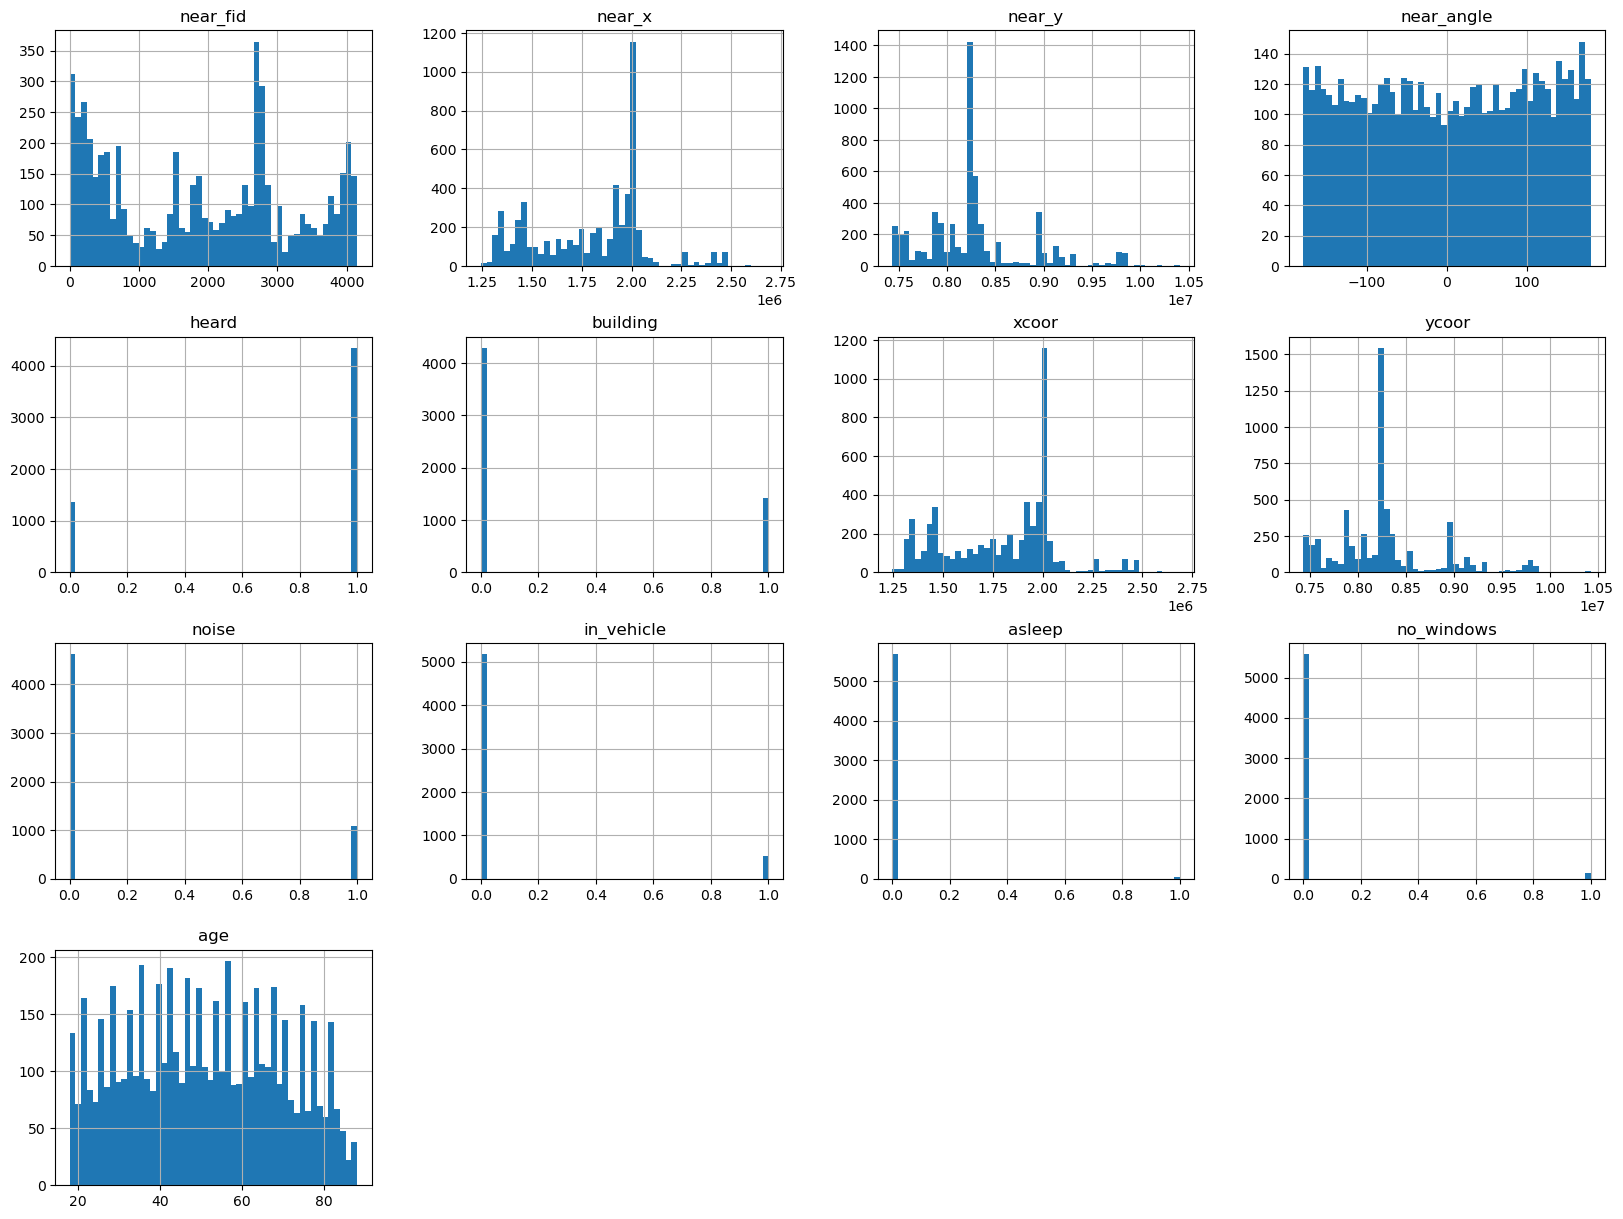

In [82]:
%matplotlib inline

data.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#compare performances, stratified sampling is better for age group

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def split_comparison(data, target_column, test_size=0.2, random_state=None):
    # Original data overall performance
    overall_performance = data[target_column].value_counts(normalize=True)
    
    # Stratified Sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, data[target_column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    
    # Random Sampling
    rand_train_set, rand_test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Calculate performance metrics for stratified sampling
    strat_train_performance = strat_train_set[target_column].value_counts(normalize=True)
    strat_test_performance = strat_test_set[target_column].value_counts(normalize=True)
    
    # Calculate performance metrics for random sampling
    rand_train_performance = rand_train_set[target_column].value_counts(normalize=True)
    rand_test_performance = rand_test_set[target_column].value_counts(normalize=True)
    
    # Calculate percentage error
    strat_train_error = ((strat_train_performance - overall_performance) / overall_performance) * 100
    strat_test_error = ((strat_test_performance - overall_performance) / overall_performance) * 100
    
    rand_train_error = ((rand_train_performance - overall_performance) / overall_performance) * 100
    rand_test_error = ((rand_test_performance - overall_performance) / overall_performance) * 100
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Overall performance': overall_performance,
        'Stratified': strat_test_performance,
        'Random': rand_test_performance,
        'Strat. % error': strat_test_error,
        'Rand. % error': rand_test_error
    })
    
    return comparison_df

# Example usage:
comparison_table = split_comparison(data, target_column='age', test_size=0.2, random_state=42)
print(comparison_table)


    Overall performance  Stratified    Random  Strat. % error  Rand. % error
18             0.011033    0.011384  0.017513        3.174603      58.730159
19             0.012434    0.012259  0.014011       -1.408451      12.676056
20             0.012434    0.012259  0.008757       -1.408451     -29.577465
21             0.015762    0.015762  0.017513        0.000000      11.111111
22             0.012960    0.013135  0.014886        1.351351      14.864865
..                  ...         ...       ...             ...            ...
84             0.002977    0.002627  0.004378      -11.764706      47.058824
85             0.005429    0.005254  0.004378       -3.225806     -19.354839
86             0.003853    0.003503  0.004378       -9.090909      13.636364
87             0.003678    0.003503  0.003503       -4.761905      -4.761905
88             0.002977    0.002627  0.001751      -11.764706     -41.176471

[71 rows x 5 columns]


Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age'],
      dtype='object')


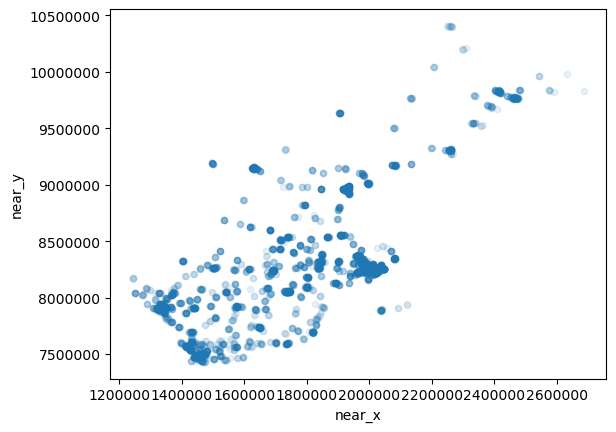

In [ ]:
print(data.columns)
data.plot(kind="scatter", x='near_x', y='near_y', alpha=0.1) #alpha highlights high-density areas
plt.ticklabel_format(style='plain', axis='both')
plt.show()

In [ ]:
#data.plot(kind="scatter", x='near_x', y='near_y', alpha=0.4,
          #s=data["age"], label="age", 
          #figsize=(10,7),
          #c="heard", cmap=plt.get_cmap("jet"), colorbar=True) #alpha highlights high-density areas
#plt.ticklabel_format(style='plain', axis='both')
#plt.show()

In [ ]:
#data.plot(kind="scatter", x='near_x', y='near_y', alpha=0.4,
          #s=data["noise"], label="noise", 
          #figsize=(10,7),
          #c="heard", cmap=plt.get_cmap("jet"), colorbar=True) #alpha highlights high-density areas
#plt.ticklabel_format(style='plain', axis='both')
#plt.show()

#s, the radius represents how many people (but not now, need to group them first)
#c, if it is heard or not


In [ ]:
#checking correlations

corr_matrix = data.corr()
corr_matrix["heard"].sort_values(ascending=False)

#we can probably group noise and in_vehicle

heard         1.000000
building      0.063283
near_angle    0.006788
xcoor         0.002301
near_x       -0.003943
near_fid     -0.120875
near_y       -0.121353
ycoor        -0.121918
asleep       -0.139777
no_windows   -0.239178
age          -0.288908
noise        -0.400162
in_vehicle   -0.406263
Name: heard, dtype: float64

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age'],
      dtype='object')


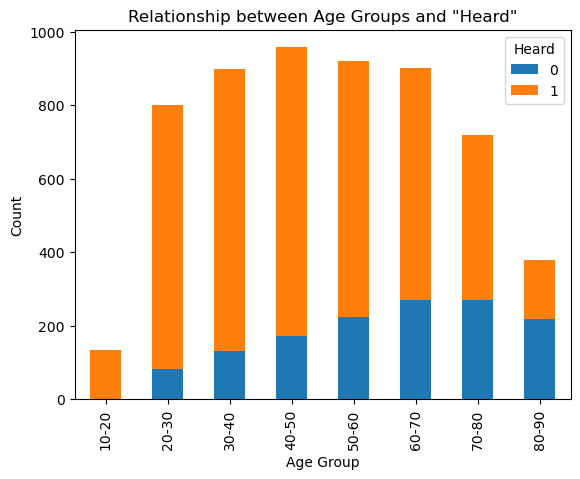

In [ ]:
from pandas.plotting import scatter_matrix
import seaborn as sns


print(data.columns)
binary_attributes = ['heard', 'building', 'noise', 'in_vehicle', 'asleep', 'no_windows']

#Comparing age and heard
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# Create stacked bar chart
pd.crosstab(data['age_group'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Relationship between Age Groups and "Heard"')
plt.legend(title='Heard')
plt.show()

In [ ]:
#data.info()
data.describe()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,distance_to_horn
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,0.248687,1.796497e+06,8.283723e+06,0.190893,0.094046,0.006130,0.023643,50.635902,7029.546722
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,0.432290,2.789790e+05,5.369782e+05,0.393039,0.291918,0.078058,0.151947,18.630865,18273.322397
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,0.000000,1.244893e+06,7.432236e+06,0.000000,0.000000,0.000000,0.000000,18.000000,5.387864
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,0.000000,1.529848e+06,7.919276e+06,0.000000,0.000000,0.000000,0.000000,35.000000,383.181746
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,0.000000,1.891302e+06,8.251345e+06,0.000000,0.000000,0.000000,0.000000,50.000000,705.204442
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,0.000000,2.003743e+06,8.368852e+06,0.000000,0.000000,0.000000,0.000000,66.000000,1629.769384
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,1.000000,2.686256e+06,1.042743e+07,1.000000,1.000000,1.000000,1.000000,88.000000,263324.337863


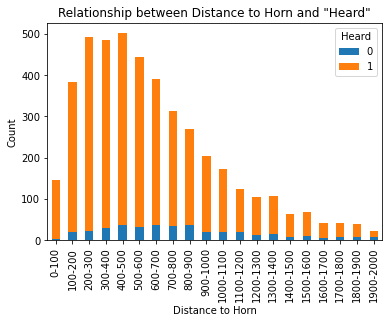

In [13]:
#comparing distance to horn and heard

import seaborn as sns

# Create bins for distance ranging from 0 to 2000 with a step size of 100
distance_bins = np.arange(0, 2001, 100)

# Create labels for distance bins
distance_labels = [f'{i}-{i+100}' for i in range(0, 2000, 100)]

# Assign each distance value to a corresponding bin
data['distance'] = pd.cut(data['distance_to_horn'], bins=distance_bins, labels=distance_labels, right=False)

#skapa procent

# Create stacked bar chart
pd.crosstab(data['distance'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Distance to Horn')
plt.ylabel('Count')
plt.title('Relationship between Distance to Horn and "Heard"')
plt.legend(title='Heard')
plt.show()


Text(0, 0.5, 'The procent hearing (%)')

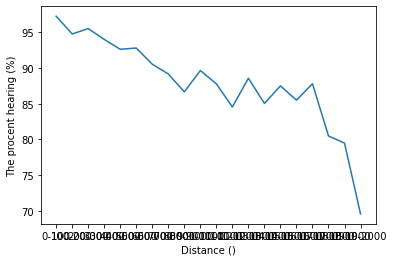

In [24]:
dist_num = data.pivot_table(index = ['distance'], columns= 'heard', aggfunc='size')

dist_num[1] = dist_num[1].fillna(0)
dist_num[0] = dist_num[0].fillna(0)
dist_num_1 = np.array(dist_num[1])
dist_num_0 = np.array(dist_num[0])

dist_procent = (dist_num_1)/(dist_num_1+dist_num_0)*100

index_dist = np.array(dist_num.index)


plt.plot(index_dist, dist_procent)
plt.xlabel('Distance ()')
plt.ylabel('The procent hearing (%)')

In [4]:
data = pd.get_dummies(data, columns=["building","noise", "in_vehicle", "asleep","no_windows" ])
data_copy = data.copy()

In [25]:
#The relationship between age and hearing
age_num = data_copy.pivot_table(index = ['age'], columns= 'heard', aggfunc='size')

age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

age_procent = (age_num_1)/(age_num_1+age_num_0)*100 #procent som hör per åldersgrupp

index_age = np.array(age_num.index)



Text(0, 0.5, 'The procent hearing (%)')

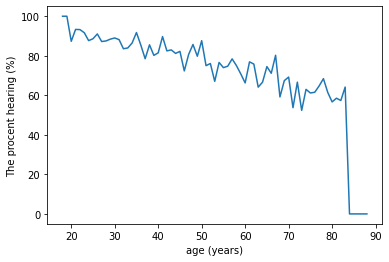

In [6]:
plt.plot(index_age, age_procent)
plt.xlabel('age (years)')
plt.ylabel('The procent hearing (%)')

In [32]:
max(data['near_angle'])

179.99204343

Text(0, 0.5, 'The procent hearing (%)')

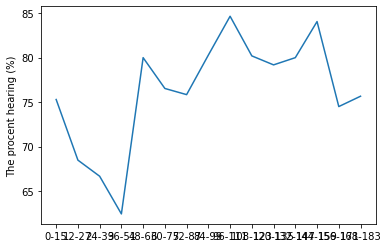

In [33]:
# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['ange_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

angle_num = data.pivot_table(index = ['ange_span'], columns= 'heard', aggfunc='size')

angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])

angle_procent = (angle_num_1 )/(angle_num_1 +angle_num_0)*100 #procent som hör

index_angle = np.array(angle_num.index)

plt.plot(index_angle, angle_procent)
plt.xlabel('')
plt.ylabel('The procent hearing (%)')


In [7]:
#Prepering the data for training and validation

data['dist'] = np.sqrt((data.near_x - data.xcoor)**2 + (data.near_y - data.ycoor)**2)

feat = ['near_fid', 'near_x', 'near_y', 'near_angle', 'xcoor', 'ycoor',
       'age', 'building_0', 'building_1', 'noise_0', 'noise_1', 'in_vehicle_0',
       'in_vehicle_1', 'asleep_0', 'asleep_1', 'no_windows_0', 'no_windows_1', 'dist']

x = data[feat] #inputs

y = data.heard # output

x = data[feat] #inputs

y = data['heard'] # output 
train_X, val_X, train_y, val_y = train_test_split(x,y, random_state=0, train_size=0.8)

In [8]:
model_tree = RandomForestClassifier()

par = {'n_estimators': stats.randint(50, 750), 'criterion':['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9], 'min_samples_split' : [1,2,3,4, 5, 6]}


RSC = RandomizedSearchCV(model_tree, param_distributions = par, n_iter = 10, cv=5, n_jobs = -1 )

RSC.fit(train_X, train_y)

model_tree = RSC.best_estimator_

model_tree.fit(train_X, train_y)

model_tree_prediction = model_tree.predict(val_X)

print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

/Users/teo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92644491 0.92688207 0.9277571  0.92819522 0.92797712 0.92622585
        nan 0.92732018 0.92710088        nan]
  warnings.warn(


heard    0    1
row_0          
0      189   21
1       63  869
acc: 0.9264448336252189


In [9]:
print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

heard    0    1
row_0          
0      189   21
1       63  869
acc: 0.9264448336252189
